In [529]:
import numpy as np
from numba import njit, prange
import matplotlib
import matplotlib.pyplot as plt

from sklearn import linear_model

from numba_progress import ProgressBar

In [ ]:

num_iterations = 100

@njit(nogil=True)
def numba_function(num_iterations, progress_proxy):
    for i in range(num_iterations):
        #<DO CUSTOM WORK HERE>
        progress_proxy.update(1)

with ProgressBar(total=num_iterations) as progress:
    numba_function(num_iterations, progress)

In [535]:
@njit
def heaviside(x):
    return (x>0)*1.

@njit(parallel = True)
def plasticity_numba(u, NE, NI, WEE, WEI, WIE, mask, TE, TI, x0, y0,
                     eta_STDP, eta_IP, HIP, TEMax, idxs_input, log,
                     progress_proxy):
    nSteps = u.size
    x = np.zeros((nSteps, NE), dtype = np.float64)
    y = np.zeros((nSteps, NI), dtype = np.float64)

    WEE_log = np.zeros(nSteps - 1, dtype = np.float64)
    TE_log = np.zeros(nSteps - 1, dtype = np.float64)

    x[0] = x0
    y[0] = y0

    for t in range(nSteps - 1):
        Input = np.zeros(NE, dtype = np.float64)
        Input[idxs_input[u[t]]] = 1

        x[t+1] = heaviside(np.dot(WEE, x[t]) - np.dot(WEI, y[t]) + Input - TE)
        y[t+1] = heaviside(np.dot(WIE, x[t]) - TI)

        old_WEE = WEE.copy()
        old_TE = TE.copy()

        for i in prange(NE):            
            SumIncoming = 0.

            for j in range(NE):
                if (j != i) and (mask[i, j] != 0):
                    DeltaWEE = x[t+1,i]*x[t,j] - x[t,i]*x[t+1,j]
                    WEE[i, j] += eta_STDP*DeltaWEE

                    if WEE[i, j] < 0:
                        WEE[i, j] = 0.
                    else:
                        SumIncoming += WEE[i, j]

            WEE[i] /= SumIncoming

            DeltaTE = (x[t+1, i] - HIP)
            TE[i] += eta_IP*DeltaTE

            if TE[i] < 0:
                TE[i] = 0
            if TE[i] > TEMax:
                TE[i] = TEMax
        if log:        
            WEE_log[t] = np.mean(np.sqrt((WEE - old_WEE)**2))
            TE_log[t] = np.mean(np.sqrt((TE - old_TE)**2))
            
        progress_proxy.update(1)
        
    return x, y, TE_log, WEE_log

@njit
def recurrent_numba(u, NE, NI, WEE, WEI, WIE, TE, TI, x0, y0,
                    idxs_input, progress_proxy):
    nSteps = u.size

    x = np.zeros((nSteps, NE), dtype = np.float64)
    y = np.zeros((nSteps, NI), dtype = np.float64)

    x[0] = x0
    y[0] = y0

    for t in range(nSteps - 1):
        Input = np.zeros(NE, dtype = np.float64)
        Input[idxs_input[u[t]]] = 1

        x[t+1] = heaviside(np.dot(WEE, x[t]) - np.dot(WEI, y[t]) + Input - TE)
        y[t+1] = heaviside(np.dot(WIE, x[t]) - TI)
        
        progress_proxy.update(1)

    return x, y

In [531]:
class SORN():
    
    def __init__(self, NE, NI, NU, lambdaW, TEMax, TIMax,
                 NSymbols, eta_STDP, eta_IP, HIP, seed = 42):
        """
        ----------
        Implementation of self-organized neural networks.
        ----------
        NE : number of excitatory neurons in the reservoir
        """
        np.random.seed(seed)
        
        self.NE = NE
        self.NI = NI
        self.NU = NU
        self.lambdaW = lambdaW
        
        self.NSymbols = NSymbols
        self.idxs_input = np.random.choice(np.arange(NE), size = (NSymbols, NU), replace = False)
        
        self.eta_STDP = eta_STDP
        self.eta_IP = eta_IP
        self.HIP = HIP
                
        #############################
        # Initialize the matrix of the network that are not going to
        # be trained. Make sure that the spectral radius of the recurrent
        # matrix is not too large.
        #############################
        
        self.WEE = np.random.rand(NE, NE)
        self.mask = np.random.choice([0,1], p = [1 - lambdaW/NE, lambdaW/NE],
                                     size = (NE, NE))
        self.WEE[self.mask == 0] = 0
        self.WEE[np.diag_indices(NE)] = 0

        self.WIE = np.random.rand(NI, NE)
        self.WEI = np.random.rand(NE, NI)

        for W in [self.WEE, self.WIE, self.WEI]:
            W /= np.sum(W, axis = 1)[..., None]

        self.TEMax = TEMax
        self.TE = np.random.uniform(0, TEMax, size = NE)
        self.TIMax = TIMax
        self.TI = np.random.uniform(0, TIMax, size = NI)
        
        self.x0 = np.random.choice([0,1], size = NE)
        self.y0 = np.random.choice([0,1], size = NI)
                
    
    def run_plasticity(self, u, log = True):
        args = (u, self.NE, self.NI, self.WEE, self.WEI, self.WIE, self.mask,
                self.TE, self.TI, self.x0, self.y0, self.eta_STDP, self.eta_IP, 
                self.HIP, self.TEMax, self.idxs_input, log)
                
        with ProgressBar(total=u.size) as progress:
            results = plasticity_numba(*args, progress)
        
        if log:
            self.x_plasticity, self.y_plasticity, self.TE_log, self.WEE_log = results
        else:
            self.x_plasticity, self.y_plasticity, _, _ = results
    
    def run_recurrent(self, u):
        args = (u, self.NE, self.NI, self.WEE, self.WEI, self.WIE,
                self.TE, self.TI, self.x0, self.y0, self.idxs_input)
        
        with ProgressBar(total=u.size) as progress:
            results = recurrent_numba(*args, progress)

        return results
        
    def train_model(self, u, initTraining):
        self.regression = linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 1000)
        
        self.x_rec, self.y_rec = self.run_recurrent(u)
        
        self.target = u[initTraining + 1:].T
        self.inputs = u[initTraining:-1]
        X = self.x_rec[initTraining + 1:, :]

        self.output_weights = self.regression.fit(X, self.target)
        
    def echo_state(self, nLoops, idx_start = None, x0 = None, y0 = None):
        output_sequence = np.ones(nLoops + 1)*(-1)
        x = np.zeros((nLoops + 1, NE), dtype = np.float64)
        y = np.zeros((nLoops + 1, NI), dtype = np.float64)
        
        if idx_start is None:
            assert x0 is not None, 'Missing initial condition x'
            assert y0 is not None, 'Missing initial condition y'
            x[0] = x0
            y[0] = y0
        else:
            x[0] = self.x_rec[idx_start + 1]
            y[0] = self.y_rec[idx_start + 1]
        
        output_sequence[0] = self.predict(x[0])
        
        for i in range(nLoops):
            x[i+1], y[i+1] = self.dynamical_step(x[i], y[i], int(output_sequence[i]))
            output_sequence[i+1] = self.predict(x[i+1])
        
        return x, y, output_sequence
            
    def predict(self, x):
        return int(self.output_weights.predict(x[..., None].T)[0])
    
    def return_input(self, input_class):
        Input = np.zeros(self.NE)
        Input[self.idxs_input[input_class]] = 1
        
        return Input
    
    def dynamical_step(self, x, y, input_class):
        new_x = heaviside(np.dot(self.WEE, x) - np.dot(SORNet.WEI, y) + self.return_input(input_class) - self.TE)
        new_y = heaviside(np.dot(self.WIE, x) - self.TI)
        
        return new_x, new_y

# Random input

In [35]:
NE = 200
NI = int(0.2*NE)
NU = 10

NSymbols = 6
lambdaW = 10

eta_STDP = 0.001
eta_IP = 0.001
HIP = 2*NU/NE

nSteps = 10000
u = np.random.choice(np.arange(NSymbols), size = nSteps)

TEMax = 0.5
TIMax = 1

In [37]:
SORNet = SORN(NE, NI, NU, lambdaW, TEMax, TIMax, NSymbols, eta_STDP, eta_IP, HIP)

In [38]:
SORNet.run_plasticity(u)

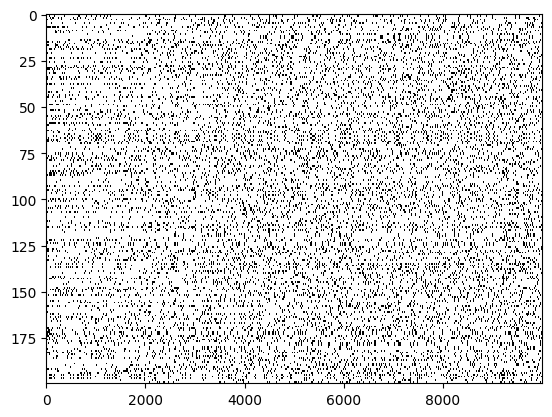

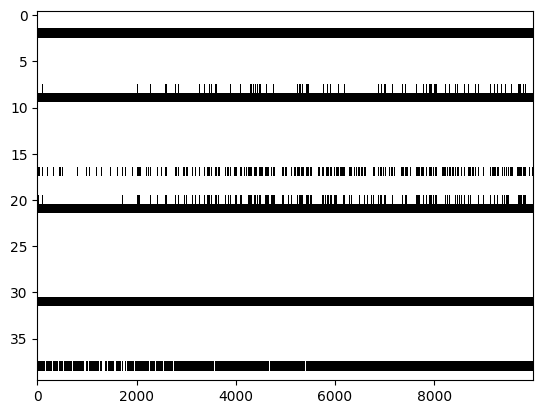

In [39]:
plt.imshow(SORNet.x_plasticity.T, cmap = "binary", aspect = "auto", interpolation = "None")
plt.show()

plt.imshow(SORNet.y_plasticity.T, cmap = "binary", aspect = "auto", interpolation = "None")
plt.show()

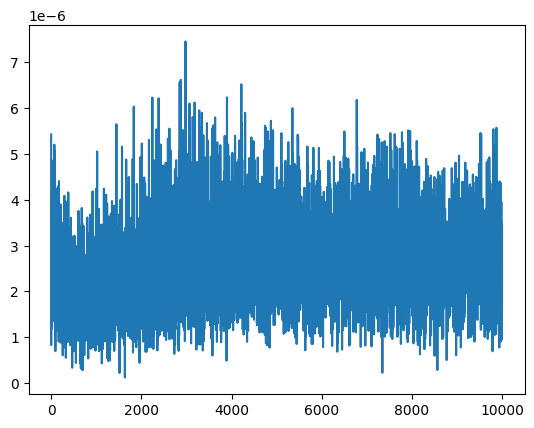

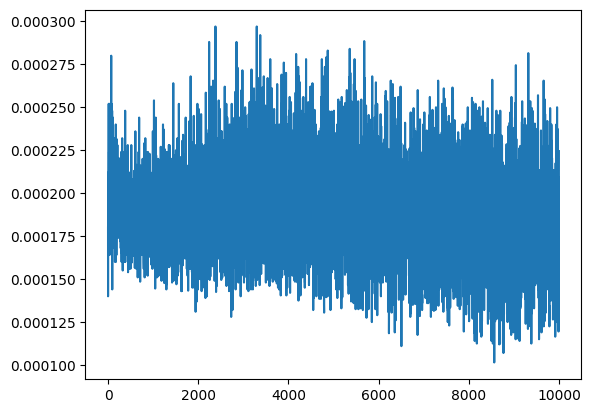

In [40]:
plt.plot(SORNet.WEE_log)
plt.show()
plt.plot(SORNet.TE_log)
plt.show()

# Structured input

In [239]:
def generate_sequence(nSteps, n):
    nWords = nSteps//(n+2)

    u = np.zeros(nSteps, dtype = np.int8)
    word_sequence = np.random.randint(2, size = nWords)

    for i in range(nWords):
        if word_sequence[i] == 0:
            word = np.array([0] + [1]*n + [2])
        else:
            word = np.array([3] + [4]*n + [5])
        u[i*(n+2):(i+1)*(n+2)] = word
        
    return u, word_sequence

In [416]:
def find_performance(ouput, verbose = False):
    idxs_word_start = np.where((ouput == 0) | (ouput == 3))[0][:-1]
    idxs_word_end   = np.where((ouput == 2) | (ouput == 5))[0]
    
    if idxs_word_start[0] > idxs_word_end[0]:
        idxs_word_end = idxs_word_end[1:]

    n = np.zeros(idxs_word_start.size)

    for i in range(idxs_word_end.size):
        if verbose:
            print(ouput[idxs_word_start[i] : idxs_word_end[i] + 1])
        n[i] = ouput[idxs_word_start[i] + 1 : idxs_word_end[i]].size

    return n.mean(), n.std()

### Working example

In [311]:
np.random.seed(424242)
NE = 400
NI = int(0.2*NE)
NU = int(0.05*NE)
lambdaW = 10

eta_STDP = 0.001
eta_IP = 0.001
HIP = 2*NU/NE

nWords = 5000
NSymbols = 6
n = 10

nSteps = 50000
u_plasticity, _ = generate_sequence(nSteps, n)

TEMax = 0.5
TIMax = 1

In [312]:
SORNet = SORN(NE, NI, NU, lambdaW, TEMax, TIMax, NSymbols, eta_STDP, eta_IP, HIP, seed = 33)

In [313]:
SORNet.run_plasticity(u_plasticity)

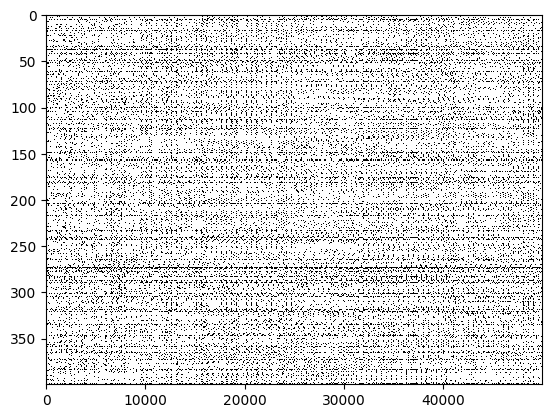

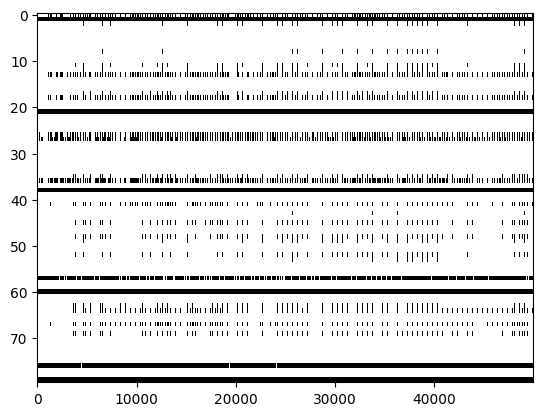

In [314]:
plt.imshow(SORNet.x_plasticity.T, cmap = "binary", aspect = "auto", interpolation = "None")
plt.show()

plt.imshow(SORNet.y_plasticity.T, cmap = "binary", aspect = "auto", interpolation = "None")
plt.show()

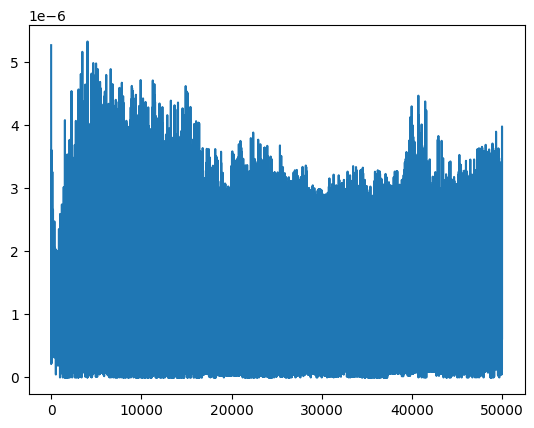

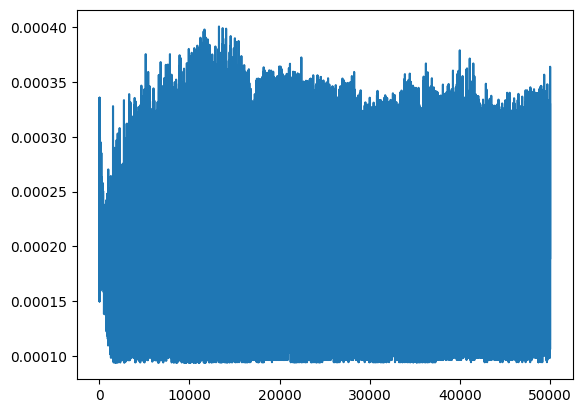

In [315]:
plt.plot(SORNet.WEE_log)
plt.show()
plt.plot(SORNet.TE_log)
plt.show()

In [316]:
nSteps = 10000

u_train, word_sequence_train = generate_sequence(nSteps, n)

In [317]:
initTraining = 200
SORNet.train_model(u_train, initTraining)

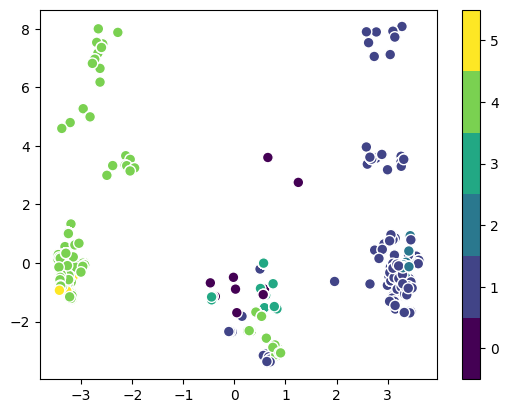

In [318]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver='full')
x_pca = pca.fit_transform(SORNet.x_rec)

plt.scatter(x_pca[:,0], x_pca[:,1], s = 60, c = u_train, ec = 'w', cmap = plt.get_cmap('viridis', NSymbols), vmin = 0, vmax = NSymbols - 1)
cbar = plt.colorbar()
tick_locs = (np.arange(NSymbols) + 0.5)*(NSymbols-1)/NSymbols
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(NSymbols))
plt.show()

[3 4 4 4 4 4 4 4 4 4 4 5]
[3 4 4 4 4 4 4 4 4 4 4 5]
[3 4 4 4 4 4 4 4 4 4 4 5]
[0 1 1 1 1 1 1 1 1 1 1 2]


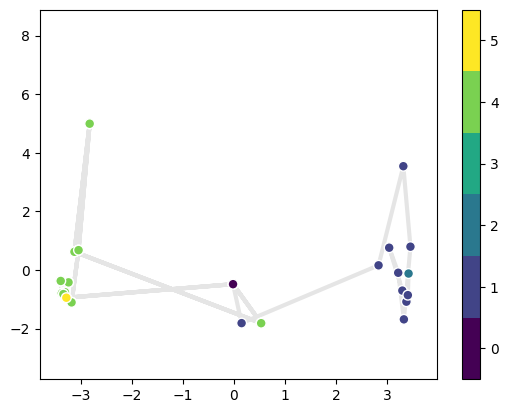

In [319]:
imin = 18
imax = 22

for i in range(imin,imax):
    plt.scatter(x_pca[(n+2)*i:(n+2)*(i+1),0], x_pca[(n+2)*i:(n+2)*(i+1),1], c = u_train[(n+2)*i:(n+2)*(i+1)],
                vmin = 0, vmax = NSymbols - 1, s = 50, zorder = np.inf, ec = 'w', cmap = plt.get_cmap('viridis', NSymbols))
    
    print(u_train[(n+2)*i:(n+2)*(i+1)])
    
plt.plot(x_pca[(n+2)*imin:(n+2)*imax,0], x_pca[(n+2)*imin:(n+2)*imax,1], lw = 3, c = 'k', alpha = 0.1)

plt.xlim(x_pca[:,0].min()*1.1, x_pca[:,0].max()*1.1)
plt.ylim(x_pca[:,1].min()*1.1, x_pca[:,1].max()*1.1)

cbar = plt.colorbar()
tick_locs = (np.arange(NSymbols) + 0.5)*(NSymbols-1)/NSymbols
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(NSymbols))

plt.show()

In [364]:
idx_start = np.where(SORNet.target == 0)[0][35]
SORNet.target[idx_start], SORNet.inputs[idx_start]

(0, 5)

In [368]:
x_echo, y_echo, output_echo = SORNet.echo_state(2000, idx_start = initTraining + idx_start)

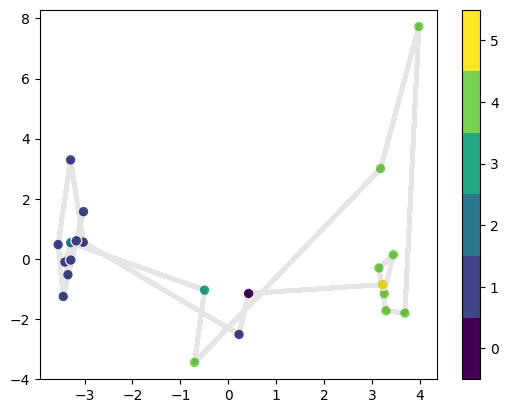

In [421]:
pca = PCA(n_components=2, svd_solver='full')
x_pca = pca.fit_transform(x_echo)

plt.plot(x_pca[:,0], x_pca[:,1], lw = 3, c = 'k', alpha = 0.1)
plt.scatter(x_pca[:,0], x_pca[:,1], s = 60, c = output_echo, ec = 'w', cmap = plt.get_cmap('viridis', NSymbols), vmin = 0, vmax = NSymbols - 1)
cbar = plt.colorbar()
tick_locs = (np.arange(NSymbols) + 0.5)*(NSymbols-1)/NSymbols
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(NSymbols))
plt.show()

In [417]:
find_performance(output_echo)

(10.0, 0.0)

In [430]:
x0 = np.random.choice([0,1], size = NE)
y0 = np.random.choice([0,1], size = NI)
x_free, y_free, output_free = SORNet.echo_state(20000, x0 = x0, y0 = y0)

In [431]:
np.unique(output_free)

array([3., 4., 5.])

In [432]:
find_performance(output_free)

(10.0, 0.0)

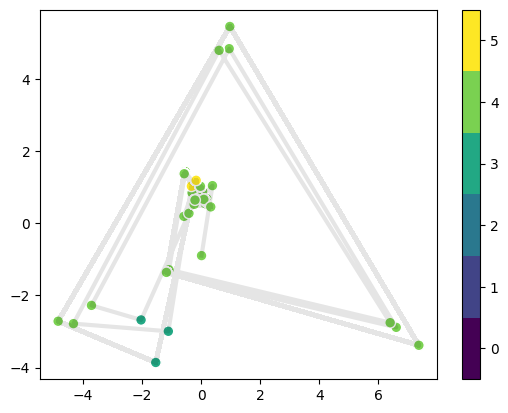

In [433]:
pca = PCA(n_components=2, svd_solver='full')
x_pca = pca.fit_transform(x_free)

plt.plot(x_pca[:,0], x_pca[:,1], lw = 3, c = 'k', alpha = 0.1)
plt.scatter(x_pca[:,0], x_pca[:,1], s = 60, c = output_free, ec = 'w', cmap = plt.get_cmap('viridis', NSymbols), vmin = 0, vmax = NSymbols - 1)
cbar = plt.colorbar()
tick_locs = (np.arange(NSymbols) + 0.5)*(NSymbols-1)/NSymbols
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(NSymbols))
plt.show()

### Smaller net

In [532]:
np.random.seed(424242)
NE = 200
NI = int(0.2*NE)
NU = int(0.05*NE)
lambdaW = 10

eta_STDP = 0.001
eta_IP = 0.001
HIP = 2*NU/NE

nWords = 5000
NSymbols = 6
n = 15

nSteps = 50000
u_plasticity, _ = generate_sequence(nSteps, n)

TEMax = 0.5
TIMax = 1

In [533]:
SORNet = SORN(NE, NI, NU, lambdaW, TEMax, TIMax, NSymbols, eta_STDP, eta_IP, HIP, seed = 8798)

In [534]:
SORNet.run_plasticity(u_plasticity)

  0%|                                                 | 0/50000 [00:00<?, ?it/s]

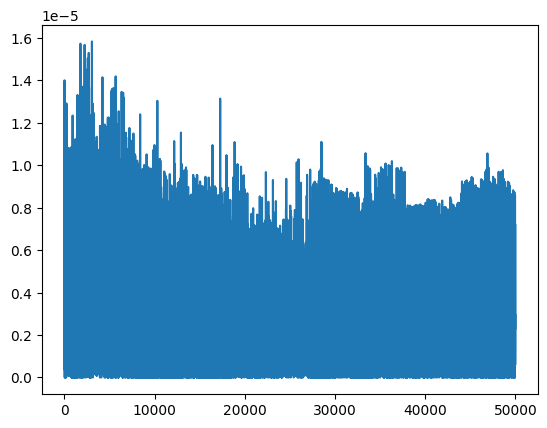

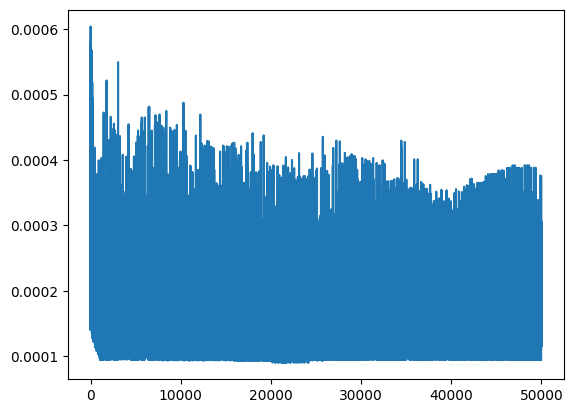

In [487]:
plt.plot(SORNet.WEE_log)
plt.show()
plt.plot(SORNet.TE_log)
plt.show()

In [488]:
nSteps = 10000

u_train, word_sequence_train = generate_sequence(nSteps, n)

In [489]:
initTraining = 200
SORNet.train_model(u_train, initTraining)

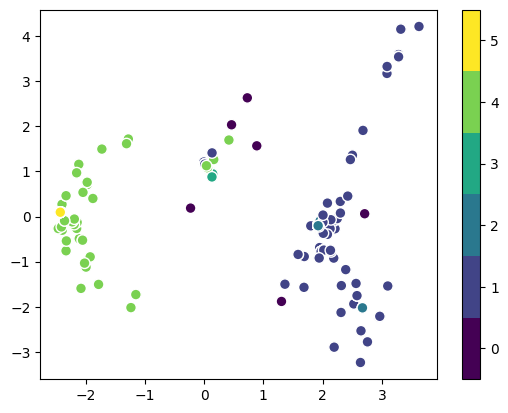

In [490]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver='full')
x_pca = pca.fit_transform(SORNet.x_rec)

plt.scatter(x_pca[:,0], x_pca[:,1], s = 60, c = u_train, ec = 'w', cmap = plt.get_cmap('viridis', NSymbols), vmin = 0, vmax = NSymbols - 1)
cbar = plt.colorbar()
tick_locs = (np.arange(NSymbols) + 0.5)*(NSymbols-1)/NSymbols
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(NSymbols))
plt.show()

In [500]:
idx_start = np.where(SORNet.target == 0)[0][85]
SORNet.target[idx_start], SORNet.inputs[idx_start]

(0, 5)

In [501]:
x_echo, y_echo, output_echo = SORNet.echo_state(2000, idx_start = initTraining + idx_start)

In [502]:
np.unique(output_echo)

array([3., 4.])

In [503]:
find_performance(output_echo)

IndexError: index 0 is out of bounds for axis 0 with size 0

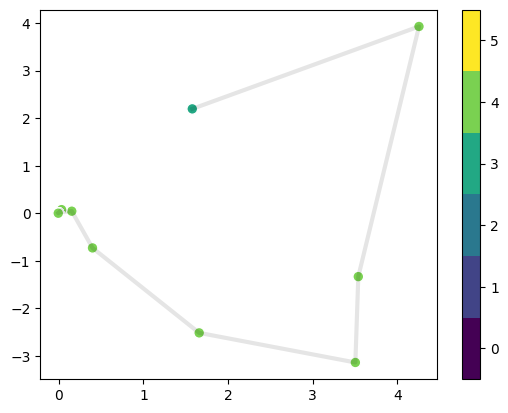

In [504]:
pca = PCA(n_components=2, svd_solver='full')
x_pca = pca.fit_transform(x_echo)

plt.plot(x_pca[:,0], x_pca[:,1], lw = 3, c = 'k', alpha = 0.1)
plt.scatter(x_pca[:,0], x_pca[:,1], s = 60, c = output_echo, ec = 'w', cmap = plt.get_cmap('viridis', NSymbols), vmin = 0, vmax = NSymbols - 1)
cbar = plt.colorbar()
tick_locs = (np.arange(NSymbols) + 0.5)*(NSymbols-1)/NSymbols
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(NSymbols))
plt.show()

In [505]:
x0 = np.random.choice([0,1], size = NE)
y0 = np.random.choice([0,1], size = NI)
x_free, y_free, output_free = SORNet.echo_state(20000, x0 = x0, y0 = y0)

In [506]:
np.unique(output_free)

array([1., 2., 3., 4.])

In [510]:
output_free[:100]

array([1., 1., 2., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])

In [507]:
find_performance(output_free)

IndexError: index 0 is out of bounds for axis 0 with size 0

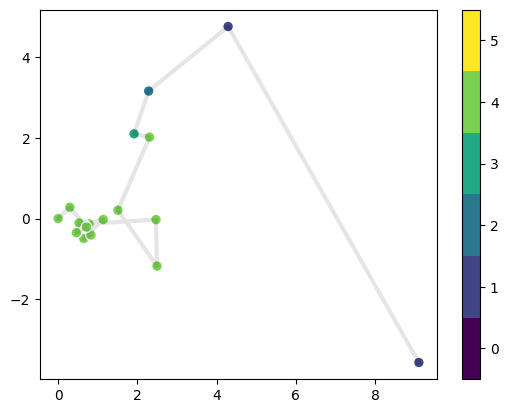

In [508]:
pca = PCA(n_components=2, svd_solver='full')
x_pca = pca.fit_transform(x_free)

plt.plot(x_pca[:,0], x_pca[:,1], lw = 3, c = 'k', alpha = 0.1)
plt.scatter(x_pca[:,0], x_pca[:,1], s = 60, c = output_free, ec = 'w', cmap = plt.get_cmap('viridis', NSymbols), vmin = 0, vmax = NSymbols - 1)
cbar = plt.colorbar()
tick_locs = (np.arange(NSymbols) + 0.5)*(NSymbols-1)/NSymbols
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(NSymbols))
plt.show()

### Large net

In [511]:
np.random.seed(424242)
NE = 800
NI = int(0.2*NE)
NU = int(0.05*NE)
lambdaW = 10

eta_STDP = 0.001
eta_IP = 0.001
HIP = 2*NU/NE

nWords = 5000
NSymbols = 6
n = 15

nSteps = 50000
u_plasticity, _ = generate_sequence(nSteps, n)

TEMax = 0.5
TIMax = 1

In [512]:
SORNet = SORN(NE, NI, NU, lambdaW, TEMax, TIMax, NSymbols, eta_STDP, eta_IP, HIP, seed = 8798)

In [513]:
SORNet.run_plasticity(u_plasticity)

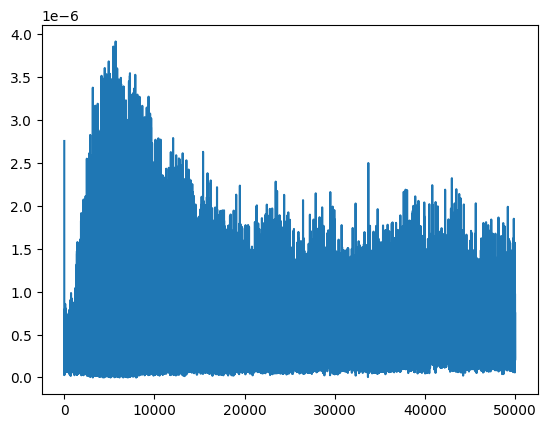

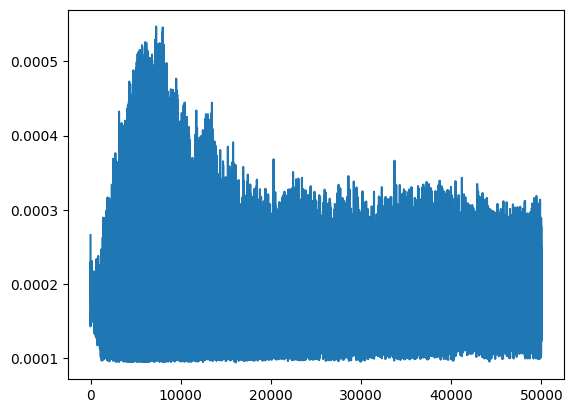

In [514]:
plt.plot(SORNet.WEE_log)
plt.show()
plt.plot(SORNet.TE_log)
plt.show()

In [515]:
nSteps = 10000

u_train, word_sequence_train = generate_sequence(nSteps, n)

In [516]:
initTraining = 200
SORNet.train_model(u_train, initTraining)

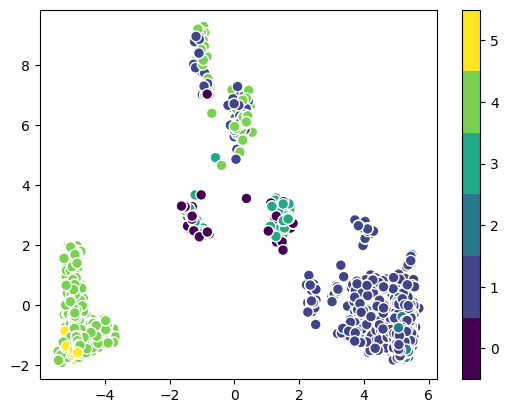

In [517]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver='full')
x_pca = pca.fit_transform(SORNet.x_rec)

plt.scatter(x_pca[:,0], x_pca[:,1], s = 60, c = u_train, ec = 'w', cmap = plt.get_cmap('viridis', NSymbols), vmin = 0, vmax = NSymbols - 1)
cbar = plt.colorbar()
tick_locs = (np.arange(NSymbols) + 0.5)*(NSymbols-1)/NSymbols
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(NSymbols))
plt.show()

In [518]:
idx_start = np.where(SORNet.target == 0)[0][85]
SORNet.target[idx_start], SORNet.inputs[idx_start]

(0, 2)

In [519]:
x_echo, y_echo, output_echo = SORNet.echo_state(2000, idx_start = initTraining + idx_start)

In [520]:
np.unique(output_echo)

array([0., 1., 2., 3., 4., 5.])

In [521]:
find_performance(output_echo)

(15.0, 0.0)

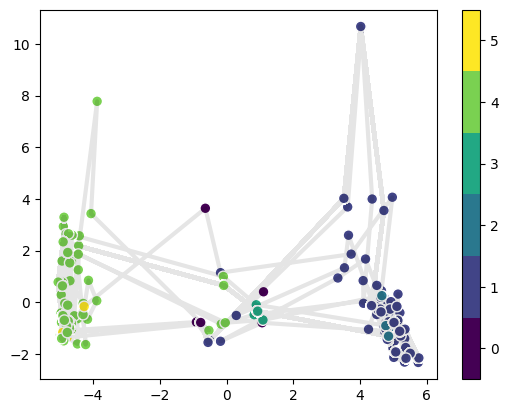

In [522]:
pca = PCA(n_components=2, svd_solver='full')
x_pca = pca.fit_transform(x_echo)

plt.plot(x_pca[:,0], x_pca[:,1], lw = 3, c = 'k', alpha = 0.1)
plt.scatter(x_pca[:,0], x_pca[:,1], s = 60, c = output_echo, ec = 'w', cmap = plt.get_cmap('viridis', NSymbols), vmin = 0, vmax = NSymbols - 1)
cbar = plt.colorbar()
tick_locs = (np.arange(NSymbols) + 0.5)*(NSymbols-1)/NSymbols
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(NSymbols))
plt.show()

In [524]:
x0 = np.random.choice([0,1], size = NE)
y0 = np.random.choice([0,1], size = NI)
x_free, y_free, output_free = SORNet.echo_state(2000, x0 = x0, y0 = y0)

In [525]:
np.unique(output_free)

array([0., 1., 2., 3., 4., 5.])

In [526]:
output_free[:100]

array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
       3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5.,
       3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5.,
       3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [527]:
find_performance(output_free)

(15.0, 0.0)

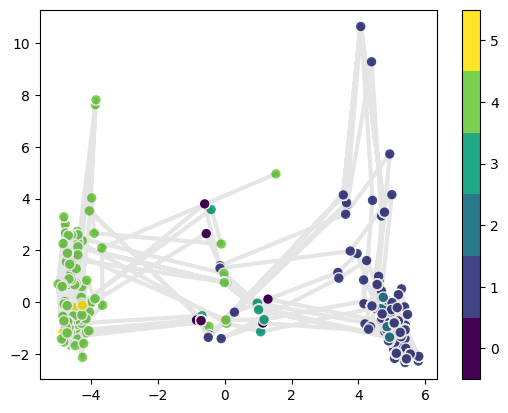

In [528]:
pca = PCA(n_components=2, svd_solver='full')
x_pca = pca.fit_transform(x_free)

plt.plot(x_pca[:,0], x_pca[:,1], lw = 3, c = 'k', alpha = 0.1)
plt.scatter(x_pca[:,0], x_pca[:,1], s = 60, c = output_free, ec = 'w', cmap = plt.get_cmap('viridis', NSymbols), vmin = 0, vmax = NSymbols - 1)
cbar = plt.colorbar()
tick_locs = (np.arange(NSymbols) + 0.5)*(NSymbols-1)/NSymbols
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(NSymbols))
plt.show()